# SC1015 Mini-Project: Spotify Music Recommender System

### By FDDA Group 5
Syed Ali Redha Alsagoff, Huang Yongjian, Ma Jinlin

## Part 2: Music Popularity Model
After applying the our genre classifier to predict the genres of our curated playlist (the pool of song where our recommendations come from!), our goal is to understand how we can better **streamline our recommendation model** such that it can **capture maximum information from user's playlist while ensuring efficiency**, so that our system can provide personalised recommendations using **lower compute**. 

To reduce the dimensionality of the features used to train our recommender system, we hypothesise a **heuristic approach of using the important factors in determining song popularity** as potential proxies for our recommender system's feature selection. This is because we believe that popular songs are in general **more likely to be recommended and enjoyed by the users**. As such, the goal of this notebook is to identify these relevant features for song popularity.

One limitation of this approach is that these features used to predict song popularity are confined to the **music's inherent characteristics** like energy, loudness etc and do not consider **the influence of Pop Culture** (which also is hard to quanitfy) that may play a bigger role in shaping the popularity of a song. With that said, our approach still can provide some insights on some of the other potential factors driving a song's popularity

## Importing Libraries

In [ ]:
!pip install xgboost

In [23]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor, XGBClassifier



## Data Cleaning and Preparation

In [13]:
# Load the dataset
dataset1_df = pd.read_csv('full_spotify_playlist_dataset.csv')  # Replace with your actual file path

# Data Cleaning
dataset1_df = dataset1_df.dropna()

# Initialize the label encoder
encoder = LabelEncoder()

dataset1_df['artist_encoded'] = encoder.fit_transform(dataset1_df['artists'])

dataset1_df['explicit'] = LabelEncoder().fit_transform(dataset1_df['explicit'])

# Focus on specified features and 'popularity'
features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
            'artist_encoded', 'genre', 'release_year', 'time_signature', 'duration_ms', 'explicit']

df_focus = dataset1_df[features + ['popularity']]

dataset1_df
df_focus


danceability  energy  key  loudness  mode  speechiness  acousticness  \
0             0.825   0.652    1    -3.183     0       0.0802       0.58100   
1             0.856   0.609    0    -7.223     1       0.0824       0.00801   
2             0.748   0.788    1    -7.055     1       0.0334       0.05910   
3             0.663   0.658    3    -7.342     0       0.0535       0.00269   
4             0.662   0.710    1    -4.945     0       0.0364       0.06030   
...             ...     ...  ...       ...   ...          ...           ...   
11788         0.853   0.604    3    -5.794     0       0.0511       0.06960   
11789         0.369   0.829   10    -3.810     1       0.0789       0.06840   
11790         0.485   0.441    1    -8.248     0       0.0775       0.46600   
11791         0.596   0.462    0   -10.605     1       0.0589       0.47600   
11792         0.762   0.054    2   -16.735     0       0.0503       0.94700   

       instrumentalness  liveness  valence    tempo  artist_encoded  genre  \
0              0.000000    0.0931    0.931   95.977            1031      5   
1              0.000082    0.0344    0.928  114.988            2223      2   
2              0.000000    0.0863    0.884  120.076            2226      5   
3              0.000519    0.4670    0.314  120.074            2149      0   
4              0.000000    0.1190    0.465  121.979            2580      3   
...                 ...       ...      ...      ...             ...    ...   
11788          0.000002    0.1350    0.860  116.000            1821      2   
11789          0.099100    0.3430    0.630  102.175            1764      6   
11790          0.000936    0.4850    0.511  140.009            1794      2   
11791          0.058100    0.1120    0.655  173.866             717      5   
11792          0.000000    0.1240    0.339   96.838            2160      2   

       release_year  time_signature  duration_ms  explicit  popularity  
0              2017               4       233713         0          87  
1              2015               4       269667         1          85  
2              2015               4       235493         1          60  
3              2024               4       153947         0          59  
4              2013               4       257267         0          21  
...             ...             ...          ...       ...         ...  
11788          2018               4       186181         0          68  
11789          2021               4       203484         0          55  
11790          2013               4       482360         0          53  
11791          2020               4       335310         0          67  
11792          2020               4       160267         0          60  

[11793 rows x 18 columns]

## Data visualisation

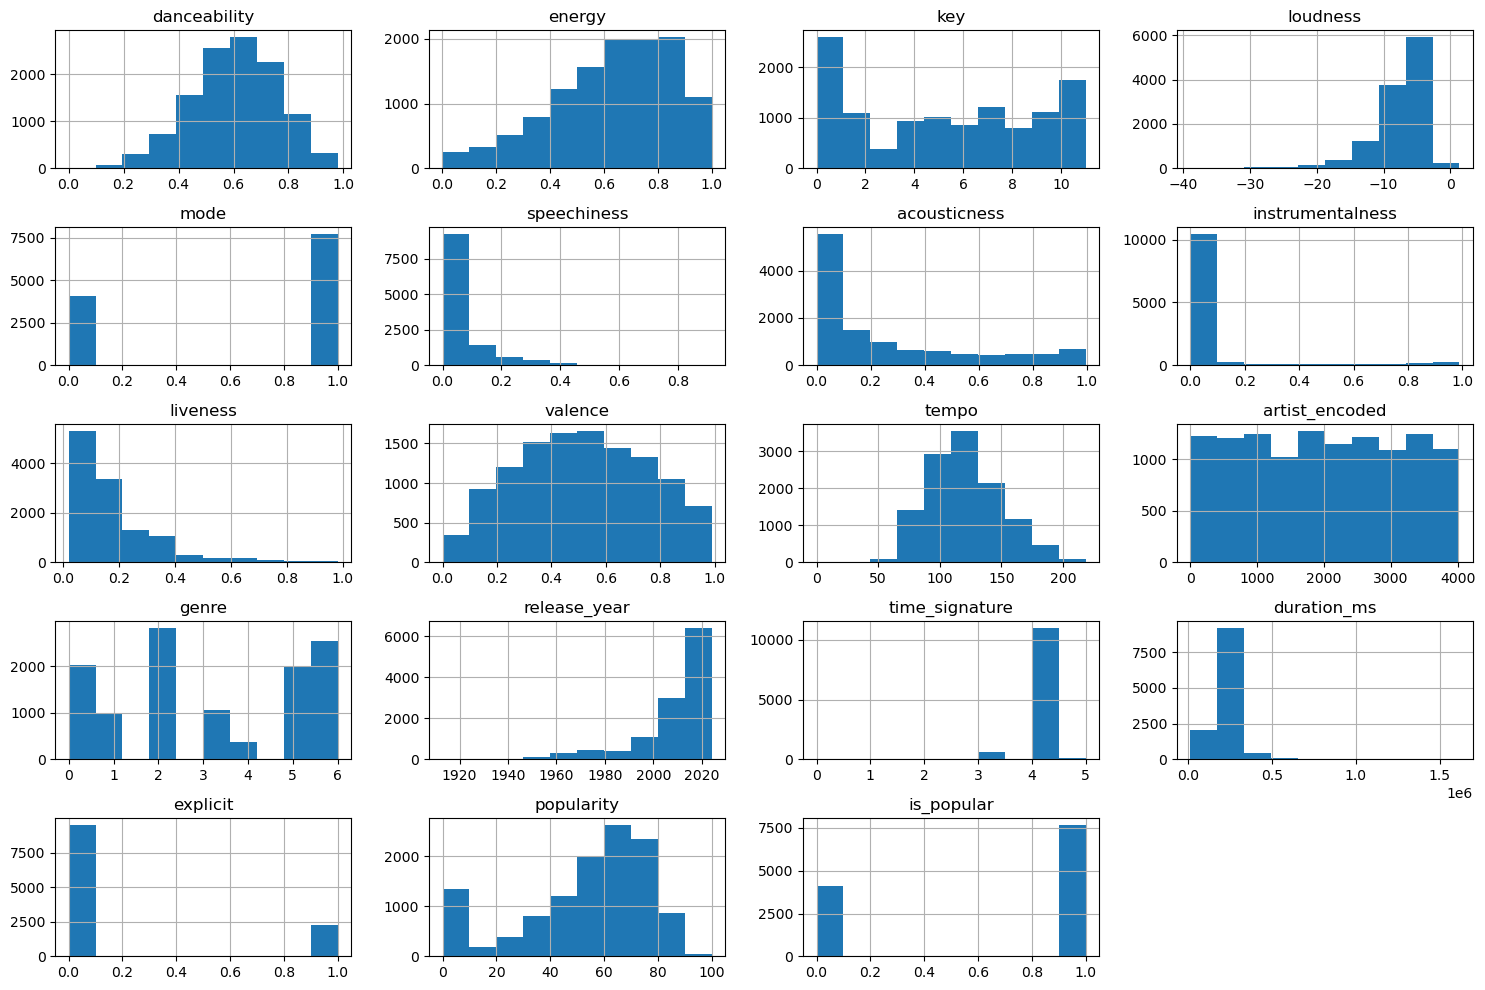

In [37]:
# General overview of data
df_focus.hist(bins=10, figsize=(15, 10), layout=(5, 4))
plt.tight_layout()
plt.show()

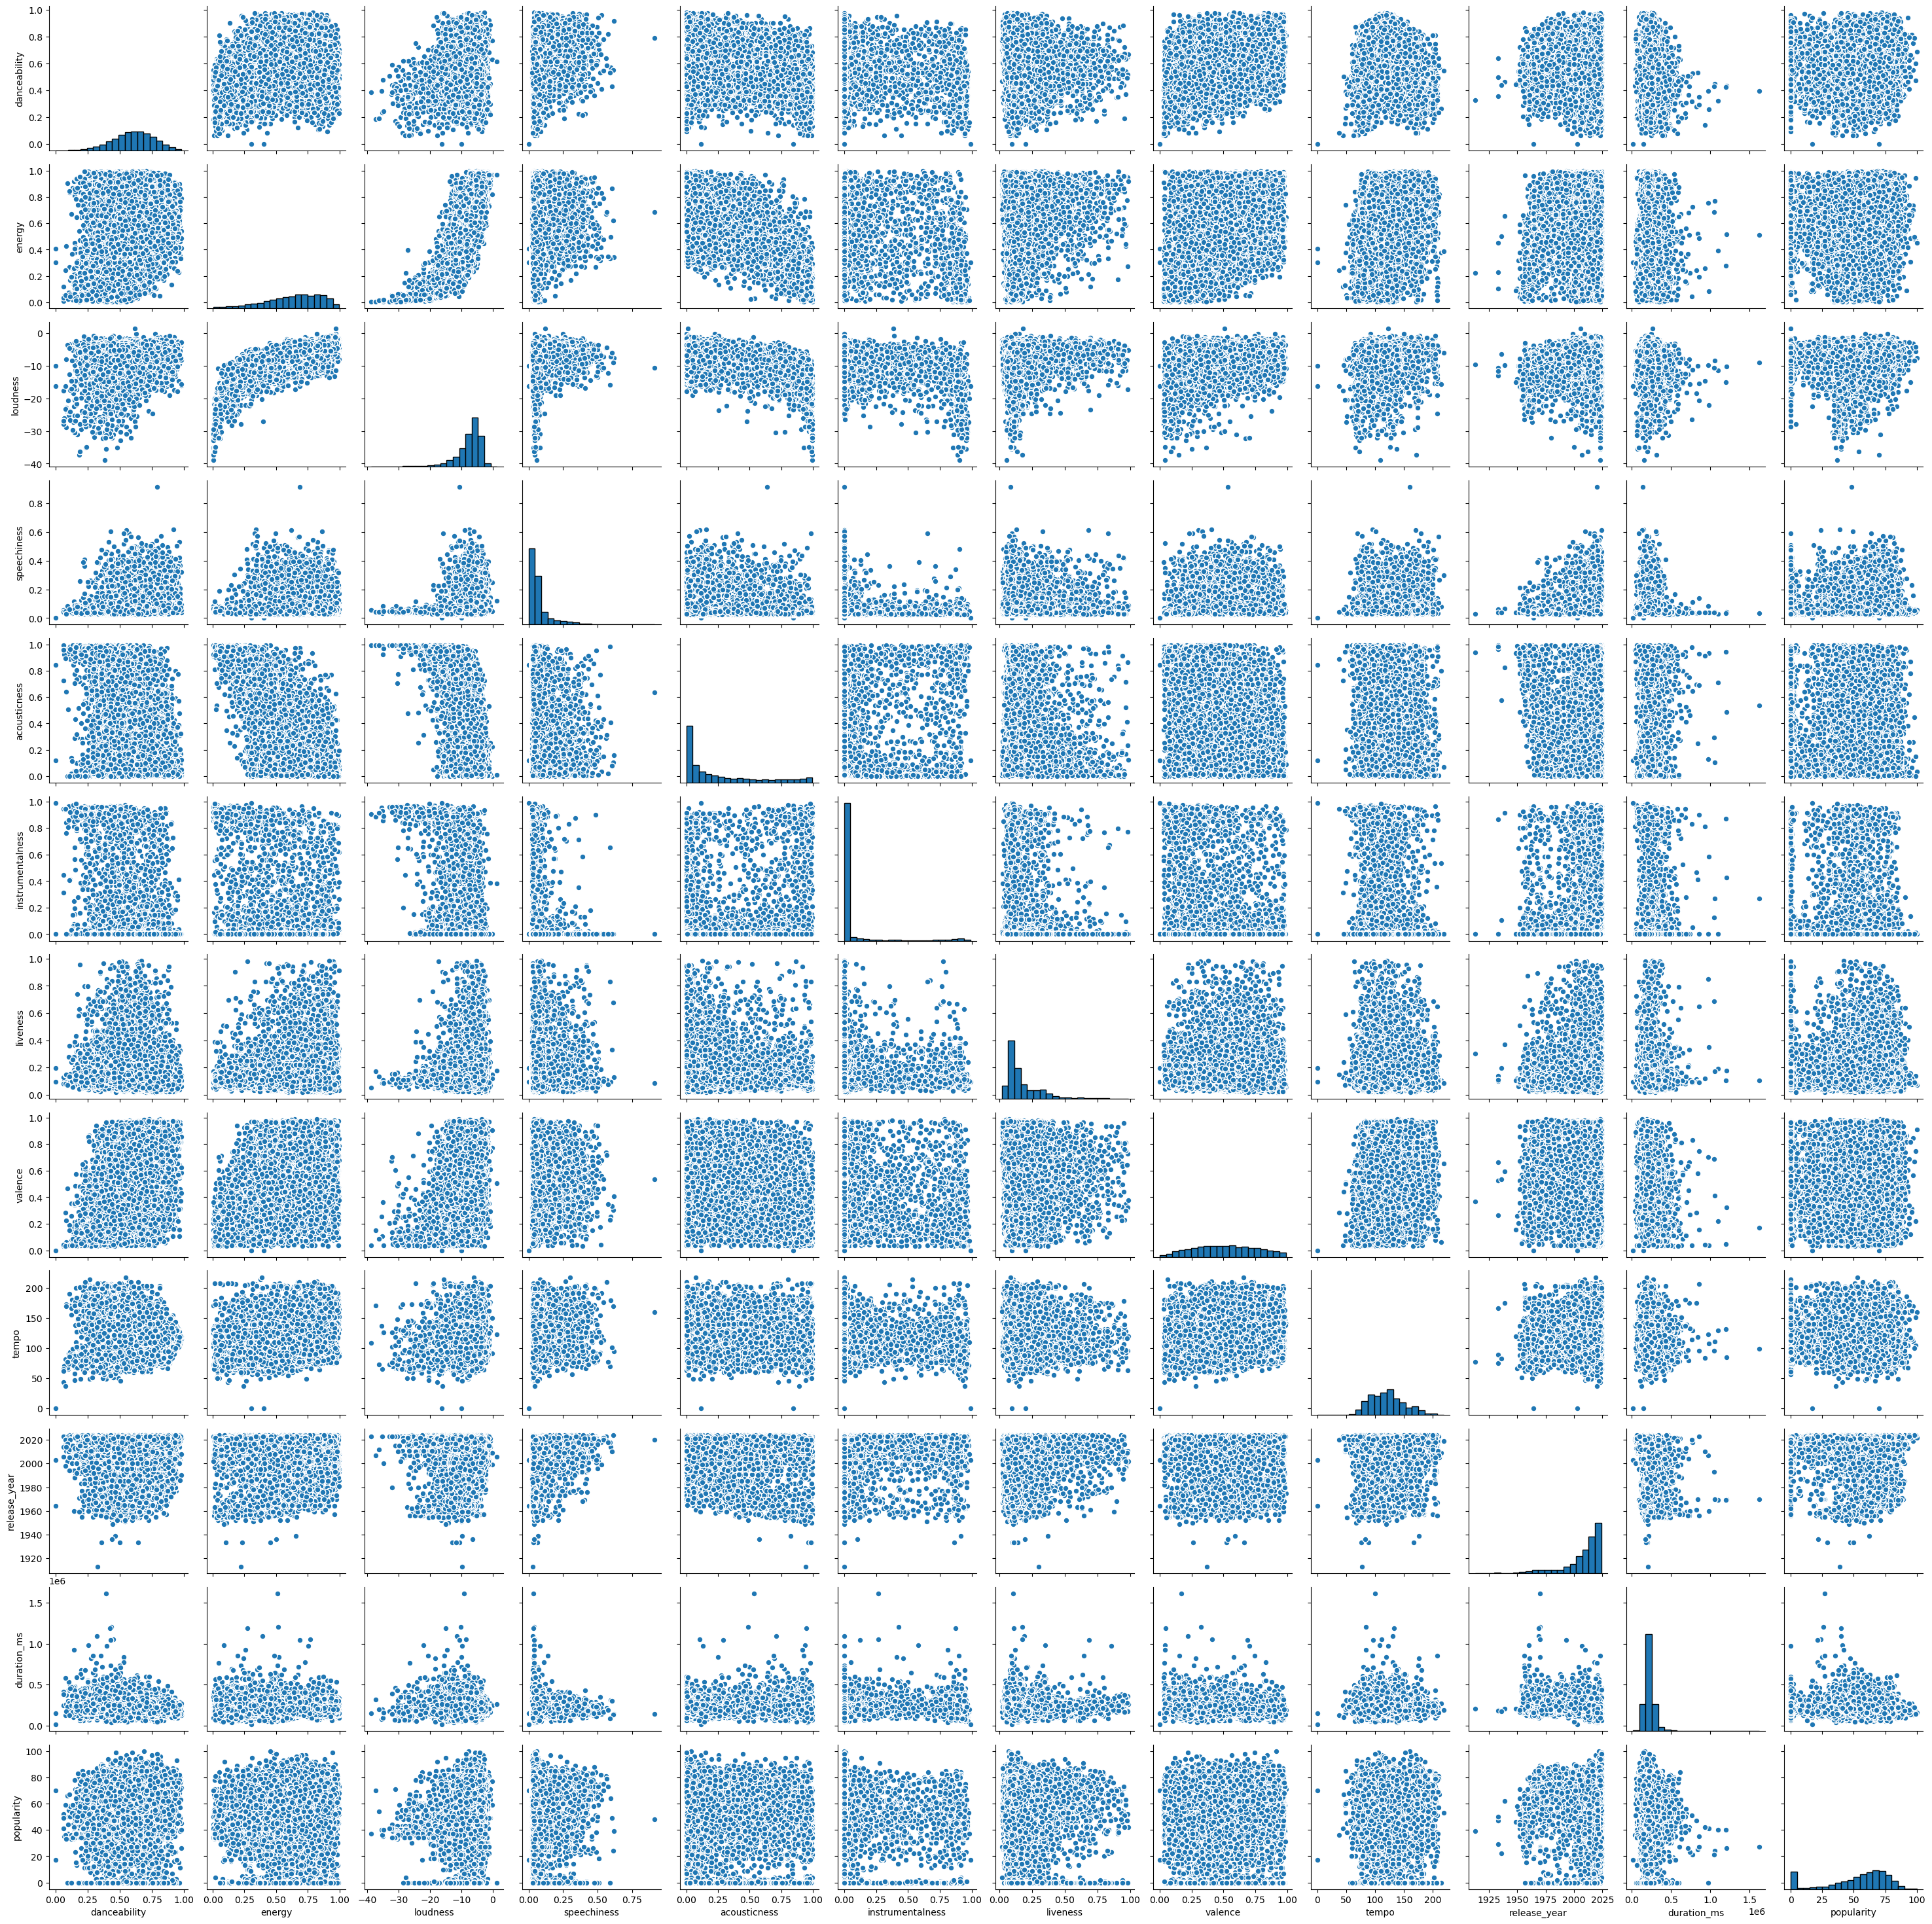

In [29]:
continuous_features = ['danceability', 'energy', 'loudness', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'release_year','duration_ms']
# Creating a PairGrid 
g = sb.PairGrid(df_focus[continuous_features + ['popularity']])
# Mapping histograms to the diagonal
g = g.map_diag(plt.hist, bins=20, edgecolor="k")
# Mapping scatter plots to the off-diagonal
g = g.map_offdiag(plt.scatter, edgecolor="w", s=40)
plt.show()

Correlation Coefficients with Popularity:
danceability: 0.0965
loudness: 0.0668
speechiness: 0.0308
valence: 0.0167
energy: 0.0147
tempo: 0.0001
liveness: -0.0197
acousticness: -0.0393
release_year: -0.0473
duration_ms: -0.0607
instrumentalness: -0.1276


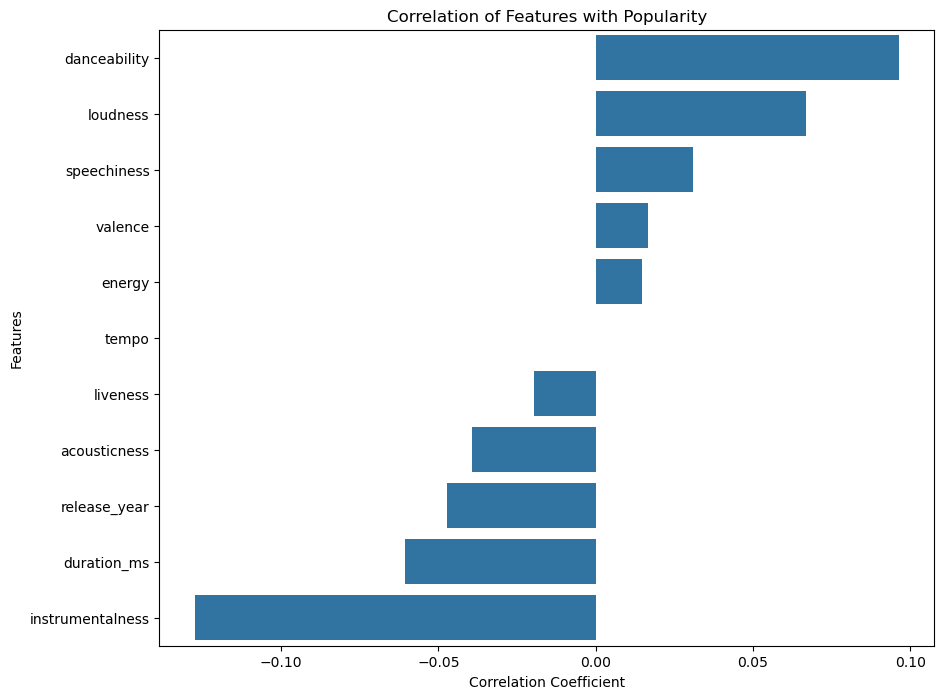

In [35]:
correlation_coefficients = {}
for feature in continuous_features:
    corr_coef = np.corrcoef(df_focus[feature], df_focus['popularity'])[0, 1]
    
    correlation_coefficients[feature] = corr_coef

print("Correlation Coefficients with Popularity:")
correlation_coefficients = {k: v for k, v in sorted(correlation_coefficients.items(), key=lambda item: item[1], reverse = True)}
for feature, corr_coef in correlation_coefficients.items():
    print(f"{feature}: {corr_coef:.4f}")
    
corr_df = pd.DataFrame(list(correlation_coefficients.items()), columns=['Feature', 'Correlation with Popularity'])
plt.figure(figsize=(10, 8))
sb.barplot(x='Correlation with Popularity', y='Feature', data=corr_df.sort_values(by='Correlation with Popularity', ascending=False))
plt.title('Correlation of Features with Popularity')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

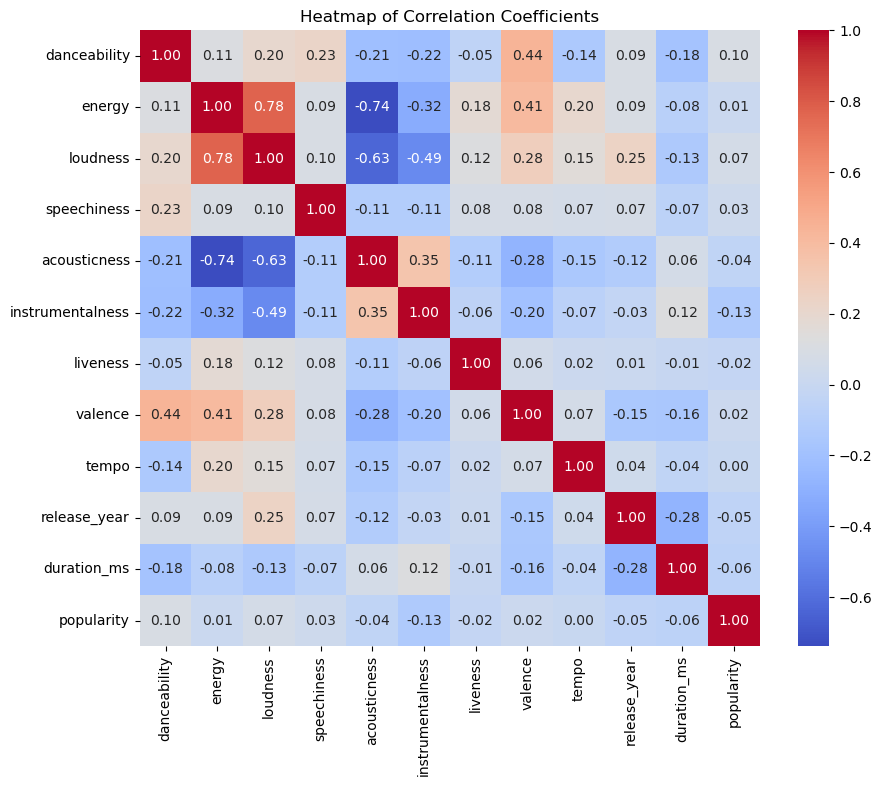

In [38]:
# Another way of visualising correlation: Heatmap
corr = df_focus[continuous_features + ['popularity']].corr()

plt.figure(figsize=(10, 8))  # Optionally specify the size of your figure
sb.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Heatmap of Correlation Coefficients')
plt.show()





Our preliminary analysis using Pearson Correlation Index has revealed that **instrumentalness (higher implies lesser vocal content) is most negatively correlated with song popularity**, implying that presence of vocal might be an important factor in deciding song popularity. On the other hand, **danceability is the most positively correlated with popularity**.

However, Pearson Correlation Index only provide a way to measure the **bivariate linearity relationship**. It does not take non-linearity and possible complications arising from interation between the various factors into account (such as collinearity). As such we will use machine learning to help us distill the relationship of each factor with popularity.

## Extreme Gradient Boosting (XGBoost) Regression model
The first way is to simply apply regression to our problem, since popularity is a continuous metric. We have decided to use XGBoost as it is one of the most powerful machine learning model available (in terms of speed and performance) for regression problems.

Classification Metrics
Mean Squared Error: 559.5559175004341
R^2 Score (Test): 0.09565767051633633
R^2 Score (Train): 0.780956202404789

Feature Importances for Regression Model:
danceability: 0.0272
energy: 0.0342
key: 0.0294
loudness: 0.0443
mode: 0.0323
speechiness: 0.0368
acousticness: 0.0437
instrumentalness: 0.0536
liveness: 0.0348
valence: 0.0431
tempo: 0.0403
artist_encoded: 0.0565
genre: 0.1638
release_year: 0.0800
time_signature: 0.0501
duration_ms: 0.0410
explicit: 0.1888


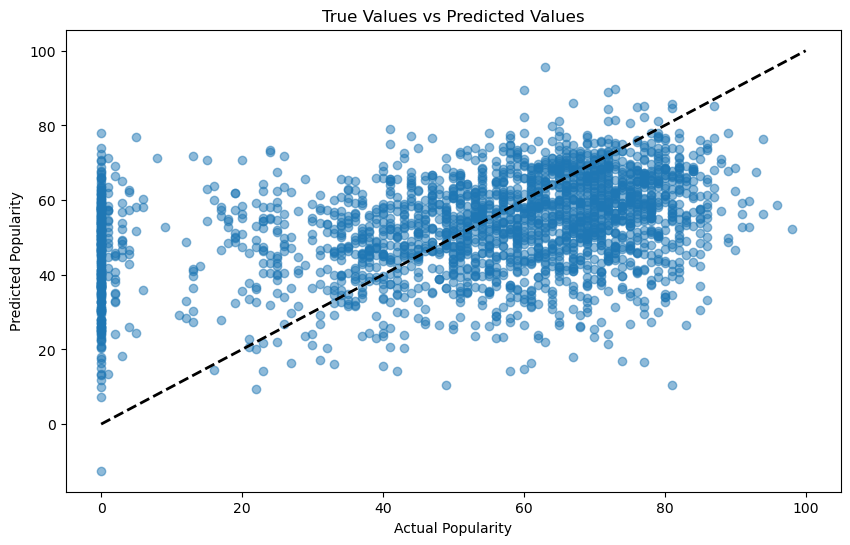

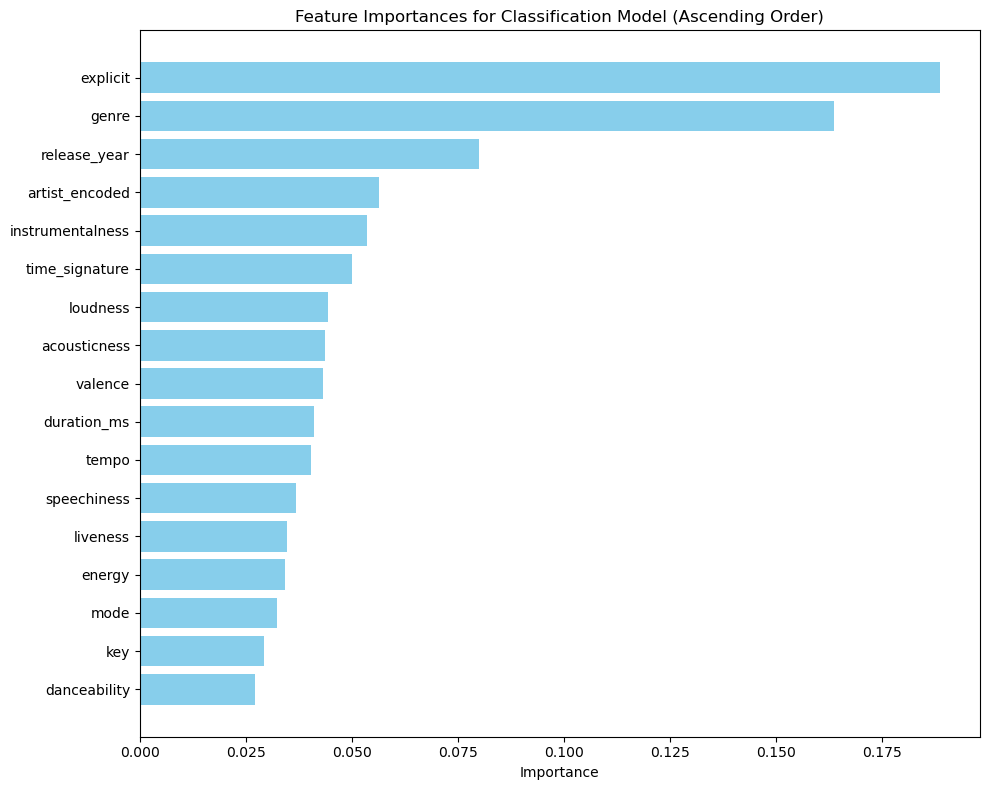

In [22]:
X = df_focus[features]
y = df_focus['popularity']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=498)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Gradient Boosting Regressor for Linear Regression model
model = XGBRegressor(objective='reg:squarederror')
model.fit(X_train_scaled, y_train)

# Predictions on the test set
y_pred = model.predict(X_test_scaled)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2_score = model.score(X_test_scaled, y_test)  # This computes the R^2 score

# Additionally, you may want to see the R^2 score for the training set as well
r2_score_train = model.score(X_train_scaled, y_train)

print("Classification Metrics")
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score (Test): {r2_score}")
print(f"R^2 Score (Train): {r2_score_train}\n")

# Regression Model Feature Importances
importance_reg = model.feature_importances_
# Printing feature importances for regression model
print("Feature Importances for Regression Model:")
for i, feature in enumerate(features):
    print(f"{feature}: {importance_reg[i]:.4f}")


# Plotting true values vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('True Values vs Predicted Values')
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')

# Drawing the ideal line for perfect predictions
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.axis('tight')

plt.show()

# Create a sorted list of tuples from feature importances and names
sorted_importances = sorted(list(zip(features, importance_reg)), key=lambda x: x[1])

# Unpack the sorted feature names and their corresponding importances
sorted_features = [x[0] for x in sorted_importances]
sorted_values = [x[1] for x in sorted_importances]

# Plotting
plt.figure(figsize=(10, 8))
y_positions = np.arange(len(sorted_features))
plt.barh(y_positions, sorted_values, color='skyblue')
plt.yticks(y_positions, sorted_features)
plt.xlabel('Importance')
plt.title('Feature Importances for Classification Model (Ascending Order)')
plt.tight_layout()
plt.show()




## XGBoost Classification model
Another way to rank the important features for music popularity is to treat the problem as binary classification. We can do using the following binary heuristic: popularity > 50 implies popular (1) and popularity <= 50 implies not popular (0).

Classification Metrics
Accuracy: 0.685459940652819
Precision: 0.7142048670062252
Recall: 0.8418945963975984
F1 Score: 0.7728107777097366

Feature Importances for Classification Model:
danceability: 0.0444
energy: 0.0445
key: 0.0351
loudness: 0.0509
mode: 0.0344
speechiness: 0.0426
acousticness: 0.0490
instrumentalness: 0.0755
liveness: 0.0410
valence: 0.0430
tempo: 0.0424
artist_encoded: 0.0584
genre: 0.1613
release_year: 0.0762
time_signature: 0.0372
duration_ms: 0.0469
explicit: 0.1171


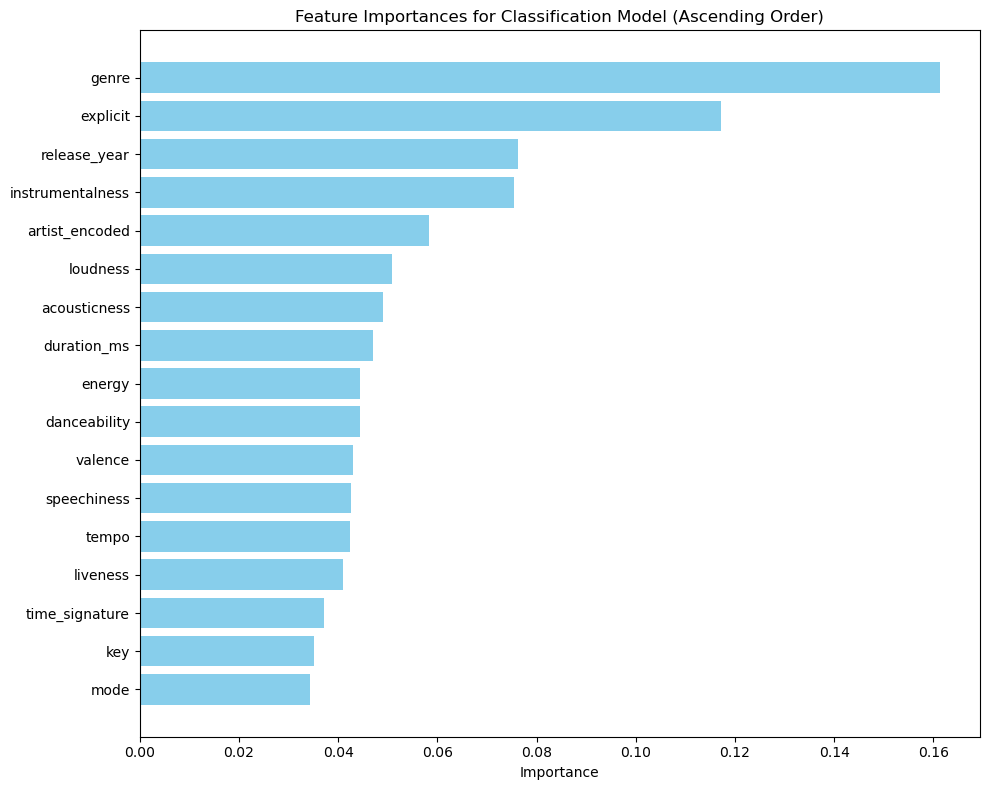

In [20]:
# Binary Classification
# Define a threshold for 'popular' songs, e.g., above 50 in popularity
df_focus = df_focus.copy()
df_focus.loc[:, 'is_popular'] = df_focus['popularity'].apply(lambda x: 1 if x > 50 else 0)


# Preparing data for binary classification
X = df_focus[features]
y = df_focus['is_popular']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=498)

# Standardizing the features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Gradient Boosting Classifier
classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
classifier.fit(X_train_scaled, y_train)

# Predictions
y_pred_class = classifier.predict(X_test_scaled)

# Evaluation
accuracy = accuracy_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)

print(f"Classification Metrics\nAccuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}")

# Classification Model Feature Importances
importance_class = classifier.feature_importances_
# Printing feature importances for classification model
print("\nFeature Importances for Classification Model:")
for i, feature in enumerate(features):
    print(f"{feature}: {importance_class[i]:.4f}")


# Create a sorted list of tuples from feature importances and names
sorted_importances = sorted(list(zip(features, importance_class)), key=lambda x: x[1])

# Unpack the sorted feature names and their corresponding importances
sorted_features = [x[0] for x in sorted_importances]
sorted_values = [x[1] for x in sorted_importances]

# Plotting
plt.figure(figsize=(10, 8))
y_positions = np.arange(len(sorted_features))
plt.barh(y_positions, sorted_values, color='skyblue')
plt.yticks(y_positions, sorted_features)
plt.xlabel('Importance')
plt.title('Feature Importances for Classification Model (Ascending Order)')
plt.tight_layout()
plt.show()



## Mean importance
We will now be taking the average of both results to give an overall ranking of feature importance for music popularity.


Mean Feature Importances:
genre: 0.1625
explicit: 0.1529
release_year: 0.0781
instrumentalness: 0.0646
artist_encoded: 0.0574
loudness: 0.0476
acousticness: 0.0464
duration_ms: 0.0440
time_signature: 0.0437
valence: 0.0431
tempo: 0.0413
speechiness: 0.0397
energy: 0.0393
liveness: 0.0379
danceability: 0.0358
mode: 0.0334
key: 0.0323


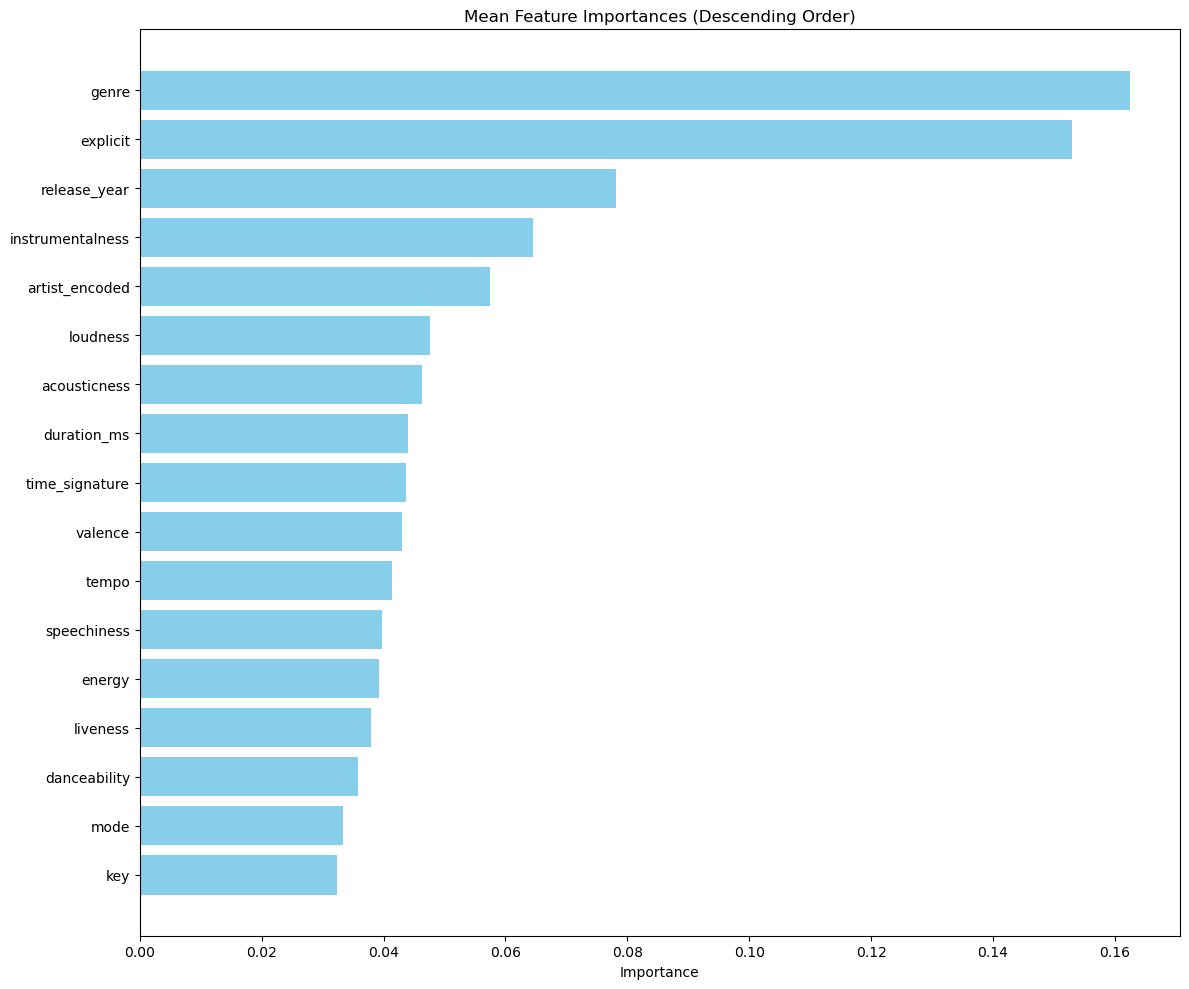

In [18]:
# Calculate mean feature importances and sort them in descending order
mean_importances = [(importance_reg[i] + importance_class[i]) / 2 for i in range(len(features))]
sorted_importances = sorted(zip(features, mean_importances), key=lambda x: x[1], reverse=True)

# Print sorted mean importances
print("\nMean Feature Importances:")
for feature, mean_importance in sorted_importances:
    print(f"{feature}: {mean_importance:.4f}")

# Unpack the sorted feature names and their corresponding importances for plotting
sorted_features = [x[0] for x in sorted_importances]
sorted_values = [x[1] for x in sorted_importances]

# Plotting the bar chart
plt.figure(figsize=(12, 10))
y_positions = np.arange(len(sorted_features))
plt.barh(y_positions, sorted_values, color='skyblue')
plt.yticks(y_positions, sorted_features)
plt.xlabel('Importance')
plt.title('Mean Feature Importances (Descending Order)')
plt.gca().invert_yaxis()  # Invert axis to display the highest values at the top
plt.tight_layout()
plt.show()

## Results
Our analysis has shown that the top 5 factors for influencing song popularity are **music genre, explicit lyrics, release year, instrumentalness and the song artist**. The worst features to predict song popularity are **key, mode and danceability**.

These factors make sense for the following reasons. Music genre and artists are obvious factors that influences one's music preference. Newer songs also tend to be more popular since they leave a stronger impression to current listeners. Presence of explicit lyrics could attract eyeball attention and influence the song popularity. Instrumentalness which measures the presence of vocal (higher implies lesser vocal content) is also important in deciding song popularity as most popular songs generally contain vocals.

Interestingly, after testing our model, we realise that danceability which was originally flagged out by the correlation coefficient was in fact not as important in our model.

With these abovementioned factors in mind, we will now proceed to creating our Spotify Song Recommender System!